&nbsp;

# 6. Final Pipeline 
A pipeline is a means of automating the machine learning workflow. What this means is that we can process and transform our data in a sequence of steps making the process of ingesting data, transforming it, and conducting predictions seamless. Also the pipeline itself can be used as an estimator, whether it's fitting data to it or making predictions. Another benefit of using pipelines aside from the obvious efficiency is that it automatically prevents data leakage from occurring (where our model learns something from the data).  

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing chosen models. 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Importing metrics.  
from sklearn.metrics import f1_score, confusion_matrix

# Importing pickle. 
from pickle import load

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
trainData = pd.read_csv(r"{}\train_new_features.csv".format(root)) # Importing the train set.
processed = pd.read_csv(r"{}\train_processed.csv".format(root))
trainData.set_index("Name", inplace=True)
trainData.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age Group,Martial Status,Survived
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,S,young adult,Not Married,0
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,female,38.0,1,0,PC 17599,71.2833,C,middle aged,Married,1


&nbsp;

### Section A: Loading the Holdout Set & Labels
In this section we're going to bring in the holdout set, which are the final 418 missing rows from the full dataset. This is the dataset that we will truely test the performance of our regularized and hypertuned models, because our algorithms have never seen this dataset before, as we separated it from our train data from the start. 

**A.1: Loading in our Holdout Set**<br>
We read in the file "test.csv" and set the "Passenger Names" as our index. We also remove columns "PassengerId" and "Cabin".

In [3]:
holdoutSet = pd.read_csv(r"{}\test.csv".format(root)).drop(columns=(["PassengerId", "Cabin"])) 
holdoutSet.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1


**A.2: Recreating our New Features**<br>
We read in the file "test.csv" and set the "Passenger Names" as our index. We also remove columns "PassengerId" and "Cabin".

In [4]:
# Creating the age group feature. 
holdoutSet = functions.create_age_group(holdoutSet)
holdoutSet.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived,Age Group
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,young adult
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1,middle aged


In [5]:
# Creating the martial status feature. 
holdoutSet = functions.create_marriage_feature(holdoutSet)
holdoutSet.set_index("Name", inplace=True)
holdoutSet.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived,Age Group,Martial Status
Name,,,,,,,,,,,
"Kelly, Mr. James",3,male,34.5,0,0,330911,7.8292,Q,0,young adult,Not Married
"Wilkes, Mrs. James (Ellen Needs)",3,female,47.0,1,0,363272,7.0000,S,1,middle aged,Married


**A.3: Splitting our Features and Label**<br>
Now it's time to split our dataset into features and label. 

In [6]:
# Rearrange columns to place label at index position [-1]. 
holdoutSet = holdoutSet[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked',
       'Age Group', 'Martial Status', 'Survived']]

# Splitting features and label.
holdoutX = holdoutSet.iloc[:,:-1]
holdoutLabels = holdoutSet.iloc[:,-1]

&nbsp;

### Section B: Evaluating on the Holdout Set
In this section we're finally going to evlauate model perfrormance on the holdout set that we have separated from our train data. Based on the results, we will pick the best performing model to use as our finalised pipeline. 

**B.1: F1_Score on the Holdoutset**<br>
First we'll create our pipeline with all of our transformers, train the estimator on our entire train dataset then use the threshold function that we created in the previous section so that our classes are predicted using the optimal threshold.

In [7]:
# Storing f1_scores over 30 iterations.
scoresLR, scoresGBC, scoresXGB = list(), list(), list()

In [8]:
# Evaluating our model on the holdout set.
functions.holdout_set_evaluation(y_axis=scoresLR, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels,
                                 model=LogisticRegression(max_iter=5000, C=1.0, penalty='elasticnet', solver='saga', 
                                 l1_ratio=0.90), threshold=0.494, model_string='Logistic Regression')

In [9]:
# Evaluating our model on the holdout set.
functions.holdout_set_evaluation(y_axis=scoresGBC, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels,
                             model=GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_split=30,
                             n_estimators=250, n_iter_no_change=20, validation_fraction=0.2, tol=2.5), threshold=0.478,
                             model_string='Gradient Boosting Classifier')

In [10]:
# Evaluating our model on the holdout set.
functions.holdout_set_evaluation(y_axis=scoresXGB, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels, 
                       model=XGBClassifier(learning_rate=0.01, max_depth=20, min_child_weight=5, 
                       n_estimators=284), threshold=0.445, model_string='XGB Classifier')

**B.2: Plotting the F1_Scores**<br> 
We will recursively predict the f1_score over 30 iterations and store the results inside an empty list. The objective is to see if there is any variance across all iterations, and to find the average scores to determine which model performed the best. We should also consider if any model shows too much volatility in their f1_scores, then it might be better to choose the model with more consistent results.

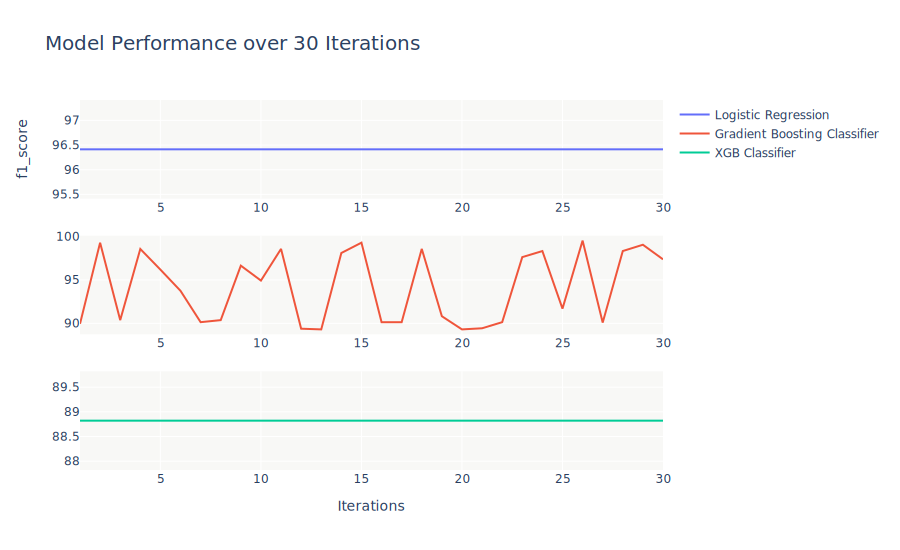

In [11]:
visuals.f1_score_plot(scoresLR, scoresGBC, scoresXGB)

In [12]:
print("The mean average score over 30 iterations for Logistic Regression is: %.4f%%" % (np.mean(scoresLR)))
print("The mean average score over 30 iterations for Gradient Boosting Classifier is: %.4f%%" % (np.mean(scoresGBC)))
print("The mean average score over 30 iterations for XGB Classifier is: %.4f%%" % (np.mean(scoresXGB)))

The mean average score over 30 iterations for Logistic Regression is: 96.4140%
The mean average score over 30 iterations for Gradient Boosting Classifier is: 94.1781%
The mean average score over 30 iterations for XGB Classifier is: 88.8209%


* The best performing classifier was Logistic Regression with an f1 score of 96.41%. 
* What's interesting to note is that our Gradient Boosting Classifier experience a lot of volatility through out its 30 iterations of predictions, whilst the XGB Classifier and Logistic Regression outputted the same f1_score over all iterations.

&nbsp;

### Section C: Saving & Loading Models
In this section we're going to export our Logistic Regression into our current working directory, then load the model back in and make the same predictions again to see if everything saved correctly. 

**C.1: Saving and Exporting our Model as a Pickle File**<br>
The first step is to save our pipeline estimator and export it as a pkl file into our current working directory.

In [13]:
# Saving our finalised model and exporting it in our cwd as a pickle file. 
functions.saving_model(train_data=trainData, model=LogisticRegression(max_iter=5000, C=1.0, penalty='elasticnet', 
                             solver='saga', l1_ratio=0.90))

**C.2: Loading our pickle File and Evaluation**<br>
The next part is to load our model back into the script and evaluate it again on the holdoutset. We run this again just to make sure that our entire pipeline components saved and loaded correctly and that our model has still retained its high performance.

In [14]:
# Loading our model back in. 
loaded_model = load(open("LogisticRegression.pkl", "rb"))

**C.3: Predicting on the Holdoutset**<br>
Now it's time to test the performance of our loaded model.

In [15]:
# Predicting probabilities on the Holdout set's features. 
yhat = loaded_model.predict_proba(holdoutX)
# Keep probabilities for the positive outcome only.
probs = yhat[:, 1]
# Convert probabilities into classes based on specified threshold value. 
classes = functions.to_labels(probs, 0.494) # Input optimal LogisticRegression threshold. 

# Using f1_score "weighted" as the preferred metric for imbalanced classification. 
score = f1_score(holdoutLabels, classes, average="weighted")*100
print(f"Logistic Regression scored an f1_score of: %.4f%% on the holdout set." % (score))

Logistic Regression scored an f1_score of: 96.4140% on the holdout set.


* It looks like our model performed exactly how it was supposed to.

&nbsp;

### Section D: Further Evaluation Metrics
In this section we're going to explore deeper into evaluating the performance of our Logistic Regression model by using the ROC AUC Curve and a Confusion Matrix.

**D.1: ROC AUC Curve**<br>
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

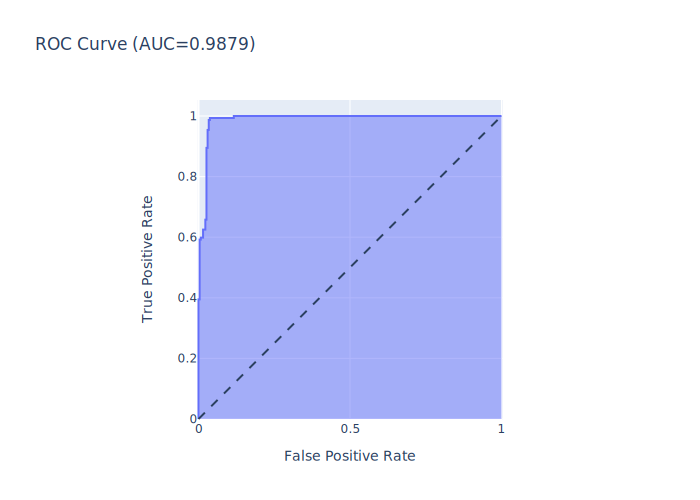

In [16]:
# Making predictions with our loaded model. 
yhat = loaded_model.predict_proba(holdoutX)[:, 1]

# Plotting our ROC_AUC curve. 
functions.ROC_AUC_curve(holdoutLabels, yhat)

* An AUC score of 1 means perfect class separability, while a score of 0.5 means the model is incapable of distinguishing between classes.
* Our AUC scored 0.9879 which is amazing. This means that our model can almost perfectly distingush between classes.
* Also our ROC curve is shaped exactly how we want it, where it's almost touching the left corner of the plot, which indicates it's an almost perfect classifier.

**D.2: Confusion Matrix**<br>
A confusion matrix is a summary of how well a classification algorithm performed by outlining its correct and incorrect predictions.

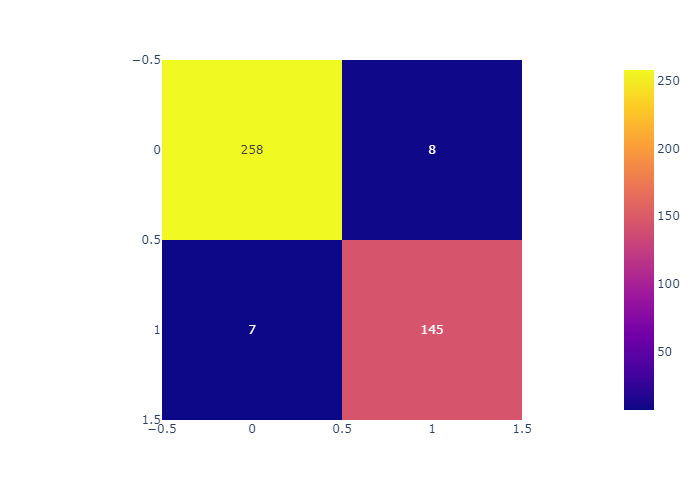

In [17]:
# Creating our confusion matrix from actuals vs predicted. 
cm = confusion_matrix(holdoutLabels, classes)
# Plot results. 
fig = px.imshow(cm, text_auto=True)
fig.show(renderer="png")

In [18]:
# Extracting [True] positive, negative and [False] positive, negative from our confusion matrix.
tn, fp, fn, tp = confusion_matrix(list(holdoutLabels), list(classes), labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 145
True Negative 258
False Positive 8
False Negative 7


* There were 145 instances where our model predicted a class to be positive and it was actually positive.
* There were 258 instances where our model predicted a class to be negative and it was actually negative.
* There were 8 instances where our model predicted a class to be positive but it was actually negative.
* There were 7 instances where our model predicted a class to be negative but it was actually positive.

**C.3: Conclusion**<br>
In conclusion we managed to train a near perfect classifier with our Logistc Regression achieving an impressive f1 score of 96.41% with zero variance over 30 predictions. Furthermore our classifier obtained an AUC score of 0.99 which indicates that it can almost perfectly distinguish between classes.  

&nbsp;

| Model | Model Type | Weighted f1_score | Threshold |Hyperparameters |  
|---------|---------|---------|---------|---------|
| **Logistic Regression** | Base Model   |96.41% | 0.494|max_iter=5000, C=1.0, penalty='elasticnet', solver='saga', l1_ratio=0.90, threshold=0.494 |
| **Gradient Boosting Classifier** | Base Model |94.77% |0.478 | learning_rate=0.1, max_depth=2, min_samples_split=30, n_estimators=250, <br>validation_fraction=0.2, n_iter_no_change=20, tol=2.5|
| **XGB Classifier** | Base Model | 88.82% |0.445 | learning_rate=0.1, max_depth=20, min_child_weight=5, n_estimators=284|

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  